In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:1


In [2]:
lr_tune = np.array([0.05,0.1,0.25,0.5,1])

In [3]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [4]:
loss_thresh = 0.5


x = np.linspace(0,1,500).reshape(-1,1)
y = np.linspace(0,1,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

# bound_pts_1 = (X == 0).reshape(-1,)
# bound_pts_2 = np.logical_and(Y == 0,X != 0).reshape(-1,)
# bound_pts_3 = np.logical_and(X == 1,Y != 0).reshape(-1,) 
# bound_pts_4 = np.logical_and(Y == 1,X != 1).reshape(-1,) 

# xy_bound_1 = xy[bound_pts_1,:]
# xy_bound_2 = xy[bound_pts_2,:]
# xy_bound_3 = xy[bound_pts_3,:]
# xy_bound_4 = xy[bound_pts_4,:]

# u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
# u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
# u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
# u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

# xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
# u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [5]:
fea_data = scipy.io.loadmat('./../ES_FEA.mat')

xy = np.array(fea_data['xy'])
u_true = np.array(fea_data['u'])

xy_test_tensor = torch.from_numpy(xy).float().to(device)
u_true_norm = np.linalg.norm(u_true,2)

In [6]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    N_t = int(N_T/4)
    
    x_BC1 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC1 = np.zeros((N_t,1))
    u_BC1 = 0*np.ones((N_t,1))
    
    x_BC2 = np.ones((N_t,1))
    y_BC2 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC2 = 1000*np.ones((N_t,1))
    
    x_BC3 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC3 = np.ones((N_t,1)) 
    u_BC3 = 0*np.ones((N_t,1))
    
    x_BC4 = np.zeros((N_t,1))
    y_BC4 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC4 = 1000*np.ones((N_t,1))
    
    XY_1 = np.hstack((x_BC1,y_BC1))
    XY_2 = np.hstack((x_BC2,y_BC2))
    XY_3 = np.hstack((x_BC3,y_BC3))
    XY_4 = np.hstack((x_BC4,y_BC4))
    
    xy_BC = np.vstack((XY_1,XY_2,XY_3,XY_4)) #choose indices from  set 'idx' (x,t)
    u_BC = np.vstack((u_BC1,u_BC2,u_BC3,u_BC4))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [7]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a =self.activation(z)
     
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = d2u_dx2 + d2u_dy2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val

    def test(self):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
     
        
        return test_mse, test_re 

In [8]:
def data_update(loss_np):
    train_loss.append(loss_np)
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [9]:
def train_step(xy_BC,u_BC,xy_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_BC,u_BC,xy_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [10]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,rep*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)
    
    nan_flag = 0
    for i in range(max_iter):
        train_step(xy_BC,u_BC,xy_coll,f_hat,i)
        loss_np = PINN.loss(xy_BC,u_BC,xy_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
            
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [11]:
nan_tune = []
for tune_reps in range(5):      
    
    max_reps = 10
    max_iter = 100 #200

    label = "MW_tanh_tune" + str(tune_reps)

    train_loss_full = []
    test_mse_full = []
    test_re_full = []

    elapsed_time= np.zeros((max_reps,1))
    time_threshold = np.empty((max_reps,1))
    time_threshold[:] = np.nan
    epoch_threshold = max_iter*np.ones((max_reps,1))


    N_T = 5000 #Total number of data points for 'y'
    N_f = 10000 #Total number of collocation points 


    for reps in range(max_reps):
        print(label)
        print(reps)
        train_loss = []
        test_mse_loss = []
        test_re_loss = []
   

        torch.manual_seed(reps*36)

        layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

        PINN = Sequentialmodel(layers)

        PINN.to(device)

        'Neural Network Summary'
        print(PINN)

        params = list(PINN.parameters())

        optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr_tune[tune_reps], 
                                  max_iter = 20, 
                                  max_eval = 30, 
                                  tolerance_grad = 1e-08, 
                                  tolerance_change = 1e-08, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')





        nan_flag = train_model(max_iter,reps)


        torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
      
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


        print('Training time: %.2f' % (elapsed_time[reps]))

    mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
    savemat(label+'.mat', mdic)

MW_tanh_tune0
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 250025.95 Test MSE 75123.7797622448 Test RE 0.47953990979729494
1 Train Loss 250000.45 Test MSE 75084.18008874205 Test RE 0.4794135042366389
2 Train Loss 250000.2 Test MSE 75083.13466735637 Test RE 0.4794101667101861
3 Train Loss 250000.2 Test MSE 75083.04151326505 Test 

98 Train Loss 250000.1 Test MSE 75082.6459637665 Test RE 0.47940860650727385
99 Train Loss 250000.1 Test MSE 75082.6459637665 Test RE 0.47940860650727385
Training time: 24.06
Training time: 24.06
MW_tanh_tune0
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 250011.08 Test MSE 75103.20043520787 Test RE 0.47947422297613257
1 Train Lo

93 Train Loss 250000.02 Test MSE 75082.27458211237 Test RE 0.47940742085525545
94 Train Loss 250000.02 Test MSE 75082.27458211237 Test RE 0.47940742085525545
95 Train Loss 250000.02 Test MSE 75082.27458211237 Test RE 0.47940742085525545
96 Train Loss 250000.02 Test MSE 75082.27458211237 Test RE 0.47940742085525545
97 Train Loss 250000.02 Test MSE 75082.27458211237 Test RE 0.47940742085525545
98 Train Loss 250000.02 Test MSE 75082.27458211237 Test RE 0.47940742085525545
99 Train Loss 250000.02 Test MSE 75082.27458211237 Test RE 0.47940742085525545
Training time: 50.48
Training time: 50.48
MW_tanh_tune0
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=Tr

89 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
90 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
91 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
92 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
93 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
94 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
95 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
96 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
97 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
98 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
99 Train Loss 250000.1 Test MSE 75082.67849216337 Test RE 0.47940871035545013
Training time: 50.28
Training time: 50.28
MW_tanh_tune0
3
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): Mo

84 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
85 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
86 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
87 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
88 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
89 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
90 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
91 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
92 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
93 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
94 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
95 Train Loss 250000.02 Test MSE 75082.40472417336 Test RE 0.47940783633975653
96 Train Loss 250000.02 Test MSE 75082.40472417336 T

79 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
80 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
81 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
82 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
83 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
84 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
85 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
86 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
87 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
88 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
89 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
90 Train Loss 250000.08 Test MSE 75082.63441677393 Test RE 0.47940856964304407
91 Train Loss 250000.08 Test MSE 75082.63441677393 T

75 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
76 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
77 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
78 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
79 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
80 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
81 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
82 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
83 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
84 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
85 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
86 Train Loss 250000.02 Test MSE 75082.39355686236 Test RE 0.47940780068761785
87 Train Loss 250000.02 Test MSE 75082.39355686236 T

70 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
71 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
72 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
73 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
74 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
75 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
76 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
77 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
78 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
79 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
80 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
81 Train Loss 250000.17 Test MSE 75083.14759343369 Test RE 0.47941020797706074
82 Train Loss 250000.17 Test MSE 75083.14759343369 T

65 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
66 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
67 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
68 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
69 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
70 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
71 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
72 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
73 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
74 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
75 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
76 Train Loss 250000.05 Test MSE 75082.33505261672 Test RE 0.47940761391015996
77 Train Loss 250000.05 Test MSE 75082.33505261672 T

61 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
62 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
63 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
64 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
65 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
66 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
67 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
68 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
69 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
70 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
71 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
72 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.47940908748303324
73 Train Loss 250000.1 Test MSE 75082.79662001376 Test RE 0.4794

57 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
58 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
59 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
60 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
61 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
62 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
63 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
64 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
65 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
66 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
67 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
68 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.4794085737780204
69 Train Loss 250000.08 Test MSE 75082.63571197365 Test RE 0.479

52 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
53 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
54 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
55 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
56 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
57 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
58 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
59 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
60 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
61 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
62 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
63 Train Loss 249999.97 Test MSE 75081.71503606332 Test RE 0.47940563447471835
64 Train Loss 249999.97 Test MSE 75081.71503606332 T

47 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
48 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
49 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
50 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
51 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
52 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
53 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
54 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
55 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
56 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
57 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
58 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.4794066015402197
59 Train Loss 250000.02 Test MSE 75082.01794868847 Test RE 0.479

43 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
44 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
45 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
46 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
47 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
48 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
49 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
50 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
51 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
52 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
53 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
54 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.4794071542459665
55 Train Loss 250000.02 Test MSE 75082.19107223996 Test RE 0.479

38 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
39 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
40 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
41 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
42 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
43 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
44 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
45 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
46 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
47 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
48 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
49 Train Loss 249999.97 Test MSE 75081.53989994267 Test RE 0.47940507534196564
50 Train Loss 249999.97 Test MSE 75081.53989994267 T

34 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
35 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
36 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
37 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
38 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
39 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
40 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
41 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
42 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
43 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
44 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
45 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772
46 Train Loss 250000.0 Test MSE 75081.92233969722 Test RE 0.4794062963033772

31 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
32 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
33 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
34 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
35 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
36 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
37 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
38 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
39 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
40 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
41 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
42 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611
43 Train Loss 250000.0 Test MSE 75081.96387803013 Test RE 0.4794064289167611

28 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
29 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
30 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
31 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
32 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
33 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
34 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
35 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
36 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
37 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
38 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
39 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
40 Train Loss 250000.0 Test MSE 75081.7668642459 Test RE 0.4794057999392289
41 Train Los

26 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
27 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
28 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
29 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
30 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
31 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
32 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
33 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
34 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
35 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
36 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
37 Train Loss 249999.97 Test MSE 75081.82218542234 Test RE 0.47940597655526407
38 Train Loss 249999.97 Test MSE 75081.82218542234 T

22 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
23 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
24 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
25 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
26 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
27 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
28 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
29 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
30 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
31 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
32 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
33 Train Loss 250000.02 Test MSE 75082.07564111649 Test RE 0.47940678572630235
34 Train Loss 250000.02 Test MSE 75082.07564111649 T

17 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
18 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
19 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
20 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
21 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
22 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
23 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
24 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
25 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
26 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
27 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
28 Train Loss 250000.08 Test MSE 75082.55909810412 Test RE 0.47940832918514653
29 Train Loss 250000.08 Test MSE 75082.55909810412 T

12 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
13 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
14 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
15 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
16 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
17 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
18 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
19 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
20 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
21 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
22 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
23 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544
24 Train Loss 250000.0 Test MSE 75081.5190703371 Test RE 0.47940500884213544

9 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
10 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
11 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
12 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
13 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
14 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
15 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
16 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
17 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
18 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
19 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
20 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
21 Train Loss 250000.0 Test MSE 75081.54346209034 Test RE 0.479405086714346
22 Train Loss

7 Train Loss 250000.0 Test MSE 75081.53031394866 Test RE 0.4794050447380759
8 Train Loss 250000.0 Test MSE 75081.51808521023 Test RE 0.47940500569705546
9 Train Loss 250000.0 Test MSE 75081.50893245146 Test RE 0.4794049764762924
10 Train Loss 250000.0 Test MSE 75081.50225030782 Test RE 0.47940495514312365
11 Train Loss 250000.0 Test MSE 75081.4967538331 Test RE 0.47940493759527775
12 Train Loss 250000.0 Test MSE 75081.49341953758 Test RE 0.4794049269503265
13 Train Loss 250000.0 Test MSE 75081.49008739527 Test RE 0.4794049163122493
14 Train Loss 250000.0 Test MSE 75081.4882262536 Test RE 0.47940491037043537
15 Train Loss 250000.0 Test MSE 75081.486463687 Test RE 0.4794049047433288
16 Train Loss 250000.0 Test MSE 75081.48519109757 Test RE 0.47940490068050545
17 Train Loss 250000.0 Test MSE 75081.48440812207 Test RE 0.47940489818080595
18 Train Loss 250000.0 Test MSE 75081.4837231163 Test RE 0.4794048959938812
19 Train Loss 250000.0 Test MSE 75081.48303820178 Test RE 0.47940489380724777


3 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
4 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
5 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
6 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
7 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
8 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
9 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
10 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
11 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
12 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
13 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
14 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477248974
15 Train Loss 250000.0 Test MSE 75081.73079075155 Test RE 0.47940568477

0 Train Loss 250027.44 Test MSE 75125.70679269885 Test RE 0.4795460601939274
1 Train Loss 250000.05 Test MSE 75082.04111303846 Test RE 0.47940667549362254
2 Train Loss 250000.0 Test MSE 75081.71105324975 Test RE 0.4794056217593502
3 Train Loss 250000.0 Test MSE 75081.65245905535 Test RE 0.4794054346938765
4 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
5 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
6 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
7 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
8 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
9 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
10 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
11 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.4794052965737543
12 Train Loss 249999.97 Test MSE 75081.60919594328 Test RE 0.47940529657375

0 Train Loss 250011.88 Test MSE 75104.40956701225 Test RE 0.4794780826332153
1 Train Loss 250000.02 Test MSE 75081.96953046172 Test RE 0.47940644696245316
2 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
3 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
4 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
5 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
6 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
7 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
8 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
9 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
10 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
11 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.4794057489917965
12 Train Loss 249999.97 Test MSE 75081.75090606166 Test RE 0.479405748991

0 Train Loss 250026.16 Test MSE 75124.07090940514 Test RE 0.4795408390406595
1 Train Loss 250000.05 Test MSE 75082.0278503366 Test RE 0.47940663315175214
2 Train Loss 250000.0 Test MSE 75081.7055432619 Test RE 0.4794056041683872
3 Train Loss 250000.0 Test MSE 75081.64882381748 Test RE 0.4794054230881596
4 Train Loss 250000.0 Test MSE 75081.60669123987 Test RE 0.4794052885773348
5 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.47940518718717684
6 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.47940518718717684
7 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.47940518718717684
8 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.47940518718717684
9 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.47940518718717684
10 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.47940518718717684
11 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.47940518718717684
12 Train Loss 249999.97 Test MSE 75081.57493299547 Test RE 0.4794051871

0 Train Loss 250022.86 Test MSE 75119.6699808255 Test RE 0.47952679257148323
1 Train Loss 250000.02 Test MSE 75081.98994394876 Test RE 0.4794065121336033
2 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
3 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
4 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
5 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
6 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
7 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
8 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
9 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
10 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
11 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
12 Train Loss 249999.97 Test MSE 75081.85883751947 Test RE 0.479406093569155
13 Trai

0 Train Loss 250000.38 Test MSE 75083.86665680316 Test RE 0.4794125036020125
1 Train Loss 250000.02 Test MSE 75081.97753812638 Test RE 0.4794064725273522
2 Train Loss 250000.0 Test MSE 75081.75491713341 Test RE 0.4794057617973771
3 Train Loss 250000.0 Test MSE 75081.68548806103 Test RE 0.4794055401409636
4 Train Loss 250000.0 Test MSE 75081.63390431249 Test RE 0.47940537545673384
5 Train Loss 250000.0 Test MSE 75081.59528455001 Test RE 0.4794052521607749
6 Train Loss 250000.0 Test MSE 75081.56677431002 Test RE 0.47940516114006587
7 Train Loss 250000.0 Test MSE 75081.54524406942 Test RE 0.479405092403426
8 Train Loss 250000.0 Test MSE 75081.5292279836 Test RE 0.4794050412710639
9 Train Loss 250000.0 Test MSE 75081.5292279836 Test RE 0.4794050412710639
10 Train Loss 250000.0 Test MSE 75081.5292279836 Test RE 0.4794050412710639
11 Train Loss 250000.0 Test MSE 75081.5292279836 Test RE 0.4794050412710639
12 Train Loss 250000.0 Test MSE 75081.5292279836 Test RE 0.4794050412710639
13 Train Lo

0 Train Loss 250002.89 Test MSE 75089.8174205808 Test RE 0.47943150111881777
1 Train Loss 250000.0 Test MSE 75081.79756721051 Test RE 0.479405897960216
2 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
3 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
4 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
5 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
6 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
7 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
8 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
9 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
10 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
11 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.47940564034640026
12 Train Loss 250000.0 Test MSE 75081.71687524051 Test RE 0.4794056403464002

0 Train Loss 250000.0 Test MSE 75081.35999914126 Test RE 0.47940450099699994
1 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
2 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
3 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
4 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
5 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
6 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
7 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
8 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
9 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
10 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
11 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
12 Train Loss 250000.0 Test MSE 75081.4203198809 Test RE 0.47940469357494647
13 Train

0 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
1 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
2 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
3 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
4 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
5 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
6 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
7 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
8 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
9 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
10 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
11 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639457
12 Train Loss 250000.0 Test MSE 75081.62093342828 Test RE 0.47940533404639

0 Train Loss 250000.0 Test MSE 75081.59168746657 Test RE 0.47940524067686385
1 Train Loss 250000.0 Test MSE 75081.53604367348 Test RE 0.4794050630305835
2 Train Loss 250000.0 Test MSE 75081.50893245146 Test RE 0.4794049764762924
3 Train Loss 250000.0 Test MSE 75081.49528255494 Test RE 0.4794049328981283
4 Train Loss 250000.0 Test MSE 75081.48861801703 Test RE 0.4794049116211651
5 Train Loss 250000.0 Test MSE 75081.48499534251 Test RE 0.47940490005554487
6 Train Loss 250000.0 Test MSE 75081.48342957032 Test RE 0.4794048950567168
7 Train Loss 250000.0 Test MSE 75081.48254903303 Test RE 0.47940489224554517
8 Train Loss 250000.0 Test MSE 75081.48205991082 Test RE 0.4794048906839911
9 Train Loss 250000.0 Test MSE 75081.48196209196 Test RE 0.47940489037169826
10 Train Loss 250000.0 Test MSE 75081.48196209196 Test RE 0.47940489037169826
11 Train Loss 250000.0 Test MSE 75081.48196209196 Test RE 0.47940489037169826
12 Train Loss 250000.0 Test MSE 75081.48196209196 Test RE 0.47940489037169826
13

0 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
1 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
2 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
3 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
4 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
5 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
6 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
7 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
8 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
9 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
10 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
11 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047731
12 Train Loss 249999.97 Test MSE 75081.75131732324 Test RE 0.4794057503047

0 Train Loss 250000.0 Test MSE 75081.60378724236 Test RE 0.47940527930614407
1 Train Loss 250000.0 Test MSE 75081.54247236272 Test RE 0.47940508355457834
2 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
3 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
4 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
5 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
6 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
7 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
8 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
9 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
10 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
11 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.47940498589672564
12 Train Loss 249999.97 Test MSE 75081.51188319409 Test RE 0.479

0 Train Loss 250000.02 Test MSE 75081.73622303712 Test RE 0.47940570211538086
1 Train Loss 249999.97 Test MSE 75081.54415501047 Test RE 0.4794050889265371
2 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
3 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
4 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
5 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
6 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
7 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
8 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
9 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
10 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
11 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
12 Train Loss 249999.97 Test MSE 75081.51267034191 Test RE 0.479404988409745
13 Tra

0 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
1 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
2 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
3 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
4 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
5 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
6 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
7 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
8 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
9 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
10 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
11 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645395
12 Train Loss 250000.0 Test MSE 75081.21694799468 Test RE 0.47940404429645

0 Train Loss 250000.0 Test MSE 75081.2621881805 Test RE 0.4794041887288809
1 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
2 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
3 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
4 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
5 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
6 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
7 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
8 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
9 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
10 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
11 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.47940453425395557
12 Train Loss 250000.0 Test MSE 75081.37041613793 Test RE 0.4794045342539555

0 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
1 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
2 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
3 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
4 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
5 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
6 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
7 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
8 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
9 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
10 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
11 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.47940541245635565
12 Train Loss 249999.97 Test MSE 75081.64549363672 Test RE 0.4

0 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
1 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
2 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
3 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
4 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
5 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
6 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
7 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
8 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
9 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
10 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
11 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.47940566189238415
12 Train Loss 249999.97 Test MSE 75081.72362405345 Test RE 0.4

0 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
1 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
2 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
3 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
4 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
5 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
6 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
7 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
8 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
9 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
10 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
11 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
12 Train Loss 250000.0 Test MSE 75081.48176645985 Test RE 0.4794048897471301
13 Train 

0 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
1 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
2 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
3 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
4 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
5 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
6 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
7 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
8 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
9 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
10 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
11 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
12 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.479404888810322

0 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
1 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
2 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
3 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
4 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
5 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
6 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
7 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
8 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
9 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
10 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
11 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
12 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
13 Train 

0 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
1 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
2 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
3 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
4 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
5 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
6 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
7 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
8 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
9 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
10 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
11 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650526
12 Train Loss 249999.97 Test MSE 75081.50313421462 Test RE 0.4794049579650

0 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
1 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
2 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
3 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
4 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
5 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
6 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
7 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
8 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
9 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
10 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
11 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
12 Train Loss 250000.0 Test MSE 75081.48186427497 Test RE 0.4794048900594111
13 Train 

0 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
1 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
2 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
3 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
4 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
5 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
6 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
7 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
8 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
9 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
10 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
11 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032256
12 Train Loss 250000.0 Test MSE 75081.48147302565 Test RE 0.47940488881032

0 Train Loss 250000.0 Test MSE 75081.48400438158 Test RE 0.4794048968918387
1 Train Loss 250000.0 Test MSE 75081.48651453372 Test RE 0.47940490490566007
2 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
3 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
4 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
5 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
6 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
7 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
8 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
9 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
10 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
11 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
12 Train Loss 250000.0 Test MSE 75081.4945961019 Test RE 0.4794049307065832
13 Train Loss 25000

0 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
1 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
2 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
3 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
4 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
5 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
6 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
7 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
8 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
9 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
10 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
11 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
12 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
13 Train 

0 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
1 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
2 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
3 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
4 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
5 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
6 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
7 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
8 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
9 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
10 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
11 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
12 Train Loss 250000.0 Test MSE 75081.48157083518 Test RE 0.4794048891225859
13 Train 

0 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
1 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
2 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
3 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
4 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
5 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
6 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
7 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
8 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
9 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
10 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
11 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
12 Train Loss 250000.0 Test MSE 75081.4816686466 Test RE 0.47940488943485493
13 Train 

In [12]:
lr_tune[0]

0.05

NameError: name 'u_pred' is not defined

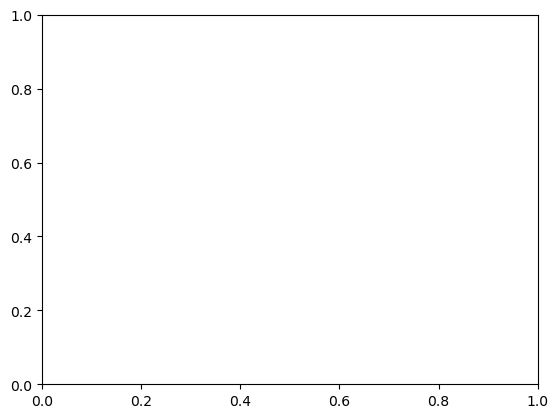

In [13]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(np.flipud(np.transpose(u_pred.reshape(500,500)))),vmin = 0,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [ ]:
import scipy.io as sio
import numpy as np

for tune_reps in range(5):
    label = "MW_tanh_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re_loss"])
    print(tune_reps," ",np.mean(re[:,-1]))

In [ ]:
lrb_tune[4]